# Introduction Azure ML<br> (expérimentations, runs, logs)
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

## 0. Paramétrage

In [1]:
import numpy as np

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
import datetime
now = datetime.datetime.now()
print(now)

2020-04-29 14:15:46.717492


In [4]:
import azureml.core
from azureml.core import Experiment, Workspace

print("Version Azure ML service : ", azureml.core.VERSION)

Version Azure ML service :  1.4.0


In [5]:
# Rappel des infos du workspace Azure ML service
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: workshopAML2020
Azure region: westeurope
Resource group: workshopAML2020-rg


In [6]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores:")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)


Compute Targets:
	 drift-aks : AKS
	 aks-pb6-obj : AKS
	 instance : ComputeInstance
	 cpu-cluster : AmlCompute
	 TrainingCompute2 : AmlCompute
	 cpu-cluster2 : AmlCompute
Datastores:
	 azureml : AzureBlob
	 modelservingdata : AzureBlob
	 aiexportdata : AzureBlob
	 modeldata : AzureBlob
	 teststorageserge : AzureBlob
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets:
	 drift-demo-dataset
	 target
	 dataset
	 Iris
	 mnist dataset
	 diabetes dataset


### Workspace Azure ML

<img src="https://github.com/retkowsky/images/blob/master/workspace.png?raw=true">

## 1. Chargement des données

In [8]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

#### Données : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [9]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [10]:
# Taille en % de la base de test
testsizepct=0.2

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [12]:
nobstrain=len(data['train']['X'])

In [13]:
nobstest=len(data['test']['X'])

In [14]:
print ("Training =", nobstrain, 'observations')
print ("Test =", nobstest, 'observations')

Training = 353 observations
Test = 89 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



In [15]:
experiment = Experiment(workspace=ws, name="Exemple1-IntroductionAML")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles
4. Sauvegarde modèle

In [21]:
def regridge(k):
    
    from datetime import datetime
    maintenant = datetime.now()

    # 1. On démarre le logging des informations
    run = experiment.start_logging()
    
    print('Test Size en % =', testsizepct) 
    print('Nbre observations Training =', nobstrain)
    print('Nbre observations Test =', nobstest)
    
    run.log('Test Size', testsizepct) # On loggue la valeur dans l'expérimentation
    run.log('Nobs Training', nobstrain) # On loggue la valeur dans l'expérimentation
    run.log('Nobs Test', nobstest) # On loggue la valeur dans l'expérimentation

    print('k =', k)
    
    # 2. Logs d'informations au run
    run.log('k', k)
    run.log('Date du Run', str(maintenant)) # On loggue la date du run

    # 3. Construction d'un modèle de régression Ridge avec la valeur de k comme hyperparamétre
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log de la métrique Mean Squared Error du modèle dans l'expérimentation
    print('MSE =', mean_squared_error(data['test']['y'], preds))
    run.log('mse', mean_squared_error(data['test']['y'], preds))

    # 5. Export modèle pour chaque valeur de k
    joblib.dump(value=regression_model, filename='modelenotebook-k-'+str(k)+'.pkl')

    # 6. Ajout de tags personnalisés au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.2.0")
    run.tag("Team", "DataScience")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Création et log d'un graphique
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("mongraphique-k-"+str(k)+".png") # On sauvegarde chaque graphique avec un nom personnalisé
    plt.title('Mon graphique', fontsize=10)
    
    run.log_image(name='Mon Graphique', plot=plt) # On loggue dans l'expérimentation l'image du graphique
    
    # 6. Fin du run
    run.complete()

Rappel: Définition MSE
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e258221518869aa1c6561bb75b99476c4734108e">

### On appelle la fonction avec différentes valeurs de k

Test Size en % = 0.2
Nbre observations Training = 353
Nbre observations Test = 89
k = 0.1
MSE = 3372.649627810032


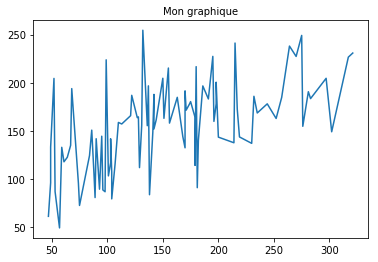

In [22]:
regridge(0.1)

Test Size en % = 0.2
Nbre observations Training = 353
Nbre observations Test = 89
k = 0.2
MSE = 3325.2946794678764


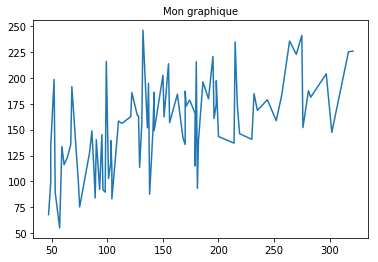

In [23]:
regridge(0.2)

Test Size en % = 0.2
Nbre observations Training = 353
Nbre observations Test = 89
k = 0.3
MSE = 3302.6736334017255


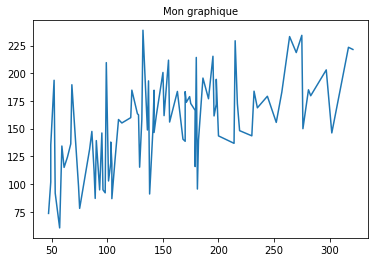

In [24]:
regridge(0.3)

Test Size en % = 0.2
Nbre observations Training = 353
Nbre observations Test = 89
k = 0.4
MSE = 3295.741064355809


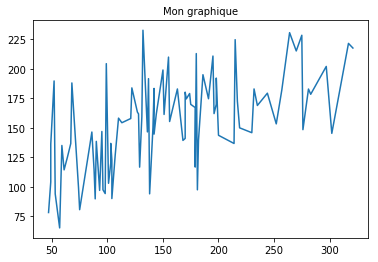

In [25]:
regridge(0.4)

Test Size en % = 0.2
Nbre observations Training = 353
Nbre observations Test = 89
k = 0.5
MSE = 3298.9096058070622


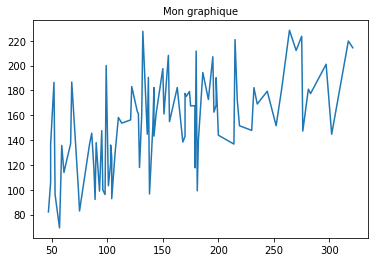

In [26]:
regridge(0.5)

In [27]:
# Liste des pickle de chaque modèle pour chaque valeur de k
%ls modelenotebook-k*.pkl -l

-rwxrwxrwx 1 root root 626 Apr 29 14:24 modelenotebook-k-0.1.pkl*
-rwxrwxrwx 1 root root 626 Apr 29 14:25 modelenotebook-k-0.2.pkl*
-rwxrwxrwx 1 root root 626 Apr 29 14:26 modelenotebook-k-0.3.pkl*
-rwxrwxrwx 1 root root 626 Apr 29 14:27 modelenotebook-k-0.4.pkl*
-rwxrwxrwx 1 root root 626 Apr 29 14:27 modelenotebook-k-0.5.pkl*


In [29]:
# Liste des graphiques pour chaque valeur de k
%ls mongraphique*.* -l

-rwxrwxrwx 1 root root 23117 Apr 29 14:24 mongraphique-k-0.1.png*
-rwxrwxrwx 1 root root 24886 Apr 29 14:25 mongraphique-k-0.2.png*
-rwxrwxrwx 1 root root 24425 Apr 29 14:26 mongraphique-k-0.3.png*
-rwxrwxrwx 1 root root 24759 Apr 29 14:27 mongraphique-k-0.4.png*
-rwxrwxrwx 1 root root 25423 Apr 29 14:27 mongraphique-k-0.5.png*


## On visualise les métriques par Run de l'expérimentation

In [30]:
# Liste des métriques par Run
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-IntroductionAML']
for logged_run in diabetes_experiment.get_runs():
    print()
    print('Run ID :', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID : ee5afe4e-1e61-4ace-a36a-f546c1a6d4cd
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- Date du Run 2020-04-29 14:27:03.475846
- mse 3298.9096058070622
- k 0.5
- Mon Graphique aml://artifactId/ExperimentRun/dcid.ee5afe4e-1e61-4ace-a36a-f546c1a6d4cd/Mon Graphique_1588170454.png

Run ID : f536f971-98a2-4528-888d-6102fedb9e28
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- Date du Run 2020-04-29 14:26:30.939067
- mse 3295.741064355809
- Mon Graphique aml://artifactId/ExperimentRun/dcid.f536f971-98a2-4528-888d-6102fedb9e28/Mon Graphique_1588170422.png
- k 0.4

Run ID : 3ce61612-8647-48d1-9023-2221051d140f
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- k 0.3
- mse 3302.6736334017255
- Date du Run 2020-04-29 14:25:57.316163
- Mon Graphique aml://artifactId/ExperimentRun/dcid.3ce61612-8647-48d1-9023-2221051d140f/Mon Graphique_1588170389.png

Run ID : 6414a2a4-b823-4bed-acb1-fca9cecc8ab2
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- k 0.2
- Date du Run 2020-04-29 

> Nous pouvons visualiser les résultats sur le portail dans la section **experiments**

In [24]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-IntroductionAML,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 3. Utilisation MLFlow

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-use-mlflow/mlflow-diagram-track.png">

Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-use-mlflow

> https://mlflow.org/

In [22]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

In [23]:
# A installer si besoin
#!pip install azureml-mlflow

In [24]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment_name = "Exemple1-MLFlow"
mlflow.set_experiment(experiment_name)

Données : 353 observations d'apprentissage et 89 observations de test.
k = 0.4
Mean Squared Error = 3295.741064355809


2020/04/22 10:01:56 WARNING mlflow.models: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under azureml://experiments/Exemple1-MLFlow/runs/15e8293e-ea6f-4a43-a6f4-455a2005b0ae/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


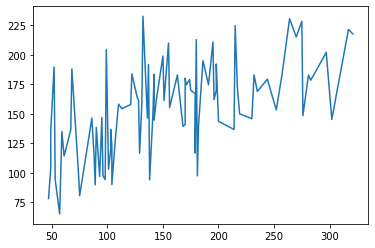

In [25]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Données :", len(data['train']['X']), "observations d'apprentissage et",len(data['test']['X']), "observations de test.")

model_save_path = "model"

k=0.4

with mlflow.start_run() as run:
    
    mlflow.log_metric('k', k)
    print('k =', k)
    
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    print('Mean Squared Error =', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("mongraphique.png")
    mlflow.log_artifact("mongraphique.png")
    

In [26]:
ws.experiments[experiment_name]

Name,Workspace,Report Page,Docs Page
Exemple1-MLFlow,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 4. Autres exemples de logging d'informations

In [27]:
experiment = Experiment(workspace=ws, name='Exemple1-Logging')

In [28]:
from tqdm import tqdm

In [29]:
# start logging for the run
run = experiment.start_logging()

# change the scale factor on different runs to see how you can compare multiple runs
scale_factor = 3

# change the category on different runs to see how to organize data in reports
category = 'Rouge'

In [30]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple1-Logging,b5826513-0a75-4706-ac25-b1d0443fb8d9,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [31]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [32]:
# log chaine de caractères
run.log(name='Category', value=category)

In [33]:
# log donneés numériques
run.log(name="scale factor", value = scale_factor)
run.log(name='Magic Number', value=42 * scale_factor)

In [34]:
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run.log_list(name='Fibonacci', value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run.log(name='Sigmoid', value=1 / (1 + np.exp(-i)))

100%|██████████| 20/20 [00:00<00:00, 6899.09it/s]


In [35]:
# create a dictionary to hold a table of values
sines = {}
sines['angle'] = []
sines['sine'] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * scale_factor
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run.log_row(name='Cosine Wave', angle=angle, cos=np.cos(angle))
        
    sines['angle'].append(angle)
    sines['sine'].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run.log_table(name='Sine Wave', value=sines)

100%|██████████| 20/20 [00:00<00:00, 7062.31it/s]


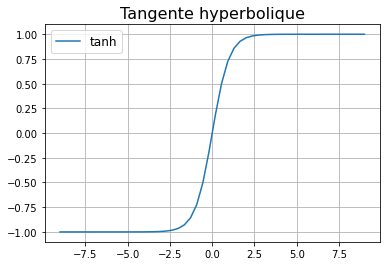

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt
angle = np.linspace(-3, 3, 50) * scale_factor
plt.plot(angle,np.tanh(angle), label='tanh')
plt.legend(fontsize=12)
plt.title('Tangente hyperbolique', fontsize=16)
plt.grid(True)

run.log_image(name='Hyperbolic Tangent', plot=plt)

In [37]:
file_name = 'outputs/myfile.txt'

with open(file_name, "w") as f:
    f.write('This is an output file that will be uploaded.\n')

# Upload the file explicitly into artifacts 
run.upload_file(name = file_name, path_or_stream = file_name)

In [38]:
run.complete()

In [39]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [40]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-Logging']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID: b5826513-0a75-4706-ac25-b1d0443fb8d9
- Hyperbolic Tangent aml://artifactId/ExperimentRun/dcid.b5826513-0a75-4706-ac25-b1d0443fb8d9/Hyperbolic Tangent_1587549743.png
- Category Rouge
- scale factor 3
- Magic Number 126
- Fibonacci [0, 3, 3, 6, 9, 15, 24, 39, 63, 102, 165, 267]
- Sigmoid [4.5397868702434395e-05, 0.00012339457598623172, 0.0003353501304664781, 0.0009110511944006454, 0.0024726231566347743, 0.0066928509242848554, 0.01798620996209156, 0.04742587317756678, 0.11920292202211755, 0.2689414213699951, 0.5, 0.7310585786300049, 0.8807970779778823, 0.9525741268224334, 0.9820137900379085, 0.9933071490757153, 0.9975273768433653, 0.9990889488055994, 0.9996646498695336, 0.9998766054240137]
- Cosine Wave {'angle': [-15.0, -13.5, -12, -10.5, -9, -7.5, -6, -4.5, -3, -1.5, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5], 'cos': [-0.7596879128588213, 0.594920663309892, 0.8438539587324921, -0.4755369279959925, -0.9111302618846769, 0.3466353178350258, 0.960170286650366, -0.2107957994307797, -

## 5. Azure Open Datasets
<img src="https://github.com/retkowsky/images/blob/master/opendata.jpg?raw=true">

> https://azure.microsoft.com/fr-fr/services/open-datasets/

In [41]:
#!pip install azureml-opendatasets

In [42]:
# Dataset jours fériés
from azureml.opendatasets import PublicHolidays

from datetime import datetime
from dateutil import parser
from dateutil.relativedelta import relativedelta

In [43]:
# Intervalle
intervalle=24
fin = datetime.today() + relativedelta(months=intervalle)
debut = datetime.today() - relativedelta(months=intervalle)

In [44]:
from datetime import datetime
maintenant = datetime.now()
print("Today :", maintenant)

Today : 2020-04-22 10:02:37.359653


In [45]:
print("Début :", debut)

Début : 2018-04-22 10:02:37.325155


In [46]:
print("Fin :", fin)

Fin : 2022-04-22 10:02:37.325039


In [47]:
hol = PublicHolidays(start_date=debut, end_date=fin)
joursferies = hol.to_pandas_dataframe()

[Info] read from https://azureopendatastorage.blob.core.windows.net/holidaydatacontainer/Processed/part-00000-tid-82382844299069370-d2708ba1-cd32-4dda-ad29-9f71ae5fb902-649-c000.snappy.parquet


In [48]:
joursferies.shape

(2220, 6)

In [49]:
joursferies.head()

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
24926,Australia,Anzac Day,Anzac Day,None,AU,2018-04-25
24927,Italy,Festa della Liberazione,Festa della Liberazione,None,IT,2018-04-25
24928,New Zealand,Anzac Day,Anzac Day,None,NZ,2018-04-25
24929,Portugal,Dia da Liberdade,Dia da Liberdade,None,PT,2018-04-25
24930,Denmark,Store bededag,Store bededag,None,DK,2018-04-27


In [50]:
# Pour avoir les jours féries en France
joursferiesFR=joursferies[joursferies.countryRegionCode == 'FR']

In [51]:
print("Nombre de jours fériés sur la période =", len(joursferiesFR.index))

Nombre de jours fériés sur la période = 44


In [52]:
joursferiesFR

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
24948,France,Fête du Travail,Fête du Travail,None,FR,2018-05-01
24976,France,Armistice 1945,Armistice 1945,None,FR,2018-05-08
24983,France,Ascension,Ascension,None,FR,2018-05-10
25006,France,Lundi de Pentecôte,Lundi de Pentecôte,None,FR,2018-05-21
25070,France,Fête nationale,Fête nationale,None,FR,2018-07-14
25096,France,Assomption,Assomption,None,FR,2018-08-15
25166,France,Toussaint,Toussaint,None,FR,2018-11-01
25183,France,Armistice 1918,Armistice 1918,None,FR,2018-11-11
25242,France,Noël,Noël,None,FR,2018-12-25
25307,France,Jour de l'an,Jour de l'an,None,FR,2019-01-01


In [53]:
# Export fichier CSV
joursferiesFR.to_csv(r'exportjoursferies.csv', index = False)

In [54]:
# Export fichier EXCEL
joursferiesFR.to_excel('exportjoursferies.xlsx')  

In [55]:
%ls exportjoursferies.* -l

-rwxrwxrwx 1 root root 2254 Apr 22 10:02 exportjoursferies.csv*
-rwxrwxrwx 1 root root 6867 Apr 22 10:02 exportjoursferies.xlsx*


<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">